# Viz sc results - no state (G main effect)

Compare pseudobulk and single-cell eQTL betas and significance for genotype main effect (PBMC-blood dataset)

In [4]:
suppressPackageStartupMessages({
    library(tidyr)
    library(dplyr)
    library(plyr)
    library(Matrix)
    library(lme4)
    library(Matrix.utils)
    library(singlecellmethods)
    library(MASS)
    library(glmnet)
    library(stringr)
    library(lmtest)
    library(lme4)
    library(ggplot2)
    library(ggrastr)
    library(RColorBrewer)
    library(forcats)
    library(ggrepel)
    library(symphony)
    library(irlba)
    library(patchwork)
})

source('../scripts/utils.R')

## Aggregate results - no state

In [5]:
nostate_NBME_results = NULL
combined_pseudobulk_results = NULL

# Loop through cell type and lead variants
for (c in c('B_plasma', 'Myeloid', 'T')) { 
    lead_pseudobulk_variants = read.csv(paste0('../eqtl_pseudobulk/4_multidataset_eQTLs/', 
                                               c, '_lead_variants.csv')) %>%
            mutate(cell_type = c) %>%
            mutate(variant_gene = paste0(variant, gene))
    # Get OneK1K single-dataset results
    OneK1K_pseudobulk_results = read.csv(paste0('../eqtl_pseudobulk/3_singledataset_eQTLs/pers_OneK1K_', 
                                            c, '_K20_pseudobulk_eQTLs.csv')) %>% 
            mutate(gene = str_replace(gene, '\\.', '-'), cell_type = c, variant_gene = paste0(variant, gene)) %>%
            filter(variant_gene %in% lead_pseudobulk_variants$variant_gene)
    
    combined_pseudobulk_results = rbind(combined_pseudobulk_results, OneK1K_pseudobulk_results) # build up pseudobulk results table
    
    # Get NBME results
    for (i in 1:nrow(lead_pseudobulk_variants)) {
        variant = lead_pseudobulk_variants[i, 'variant'] %>% unlist()
        gene = lead_pseudobulk_variants[i, 'gene']
        nostate_NBME_result = read.csv(paste0('./1_sceQTL_nostate/', 
                                                paste('OneK1K_NBME_result', c, gene, variant, sep = '_'), '.csv'), row.names = 1) %>%
                                mutate(cell_type = c)
        nostate_NBME_results = rbind(nostate_NBME_results, nostate_NBME_result) # build up single-cell results
    }
}
nostate_NBME_results_G = nostate_NBME_results %>% filter(term == 'G') 
nostate_NBME_results_G$model = 'NBME'

In [6]:
saveRDS(nostate_NBME_results_G, './1_sceQTL_nostate/nostate_res_OneK1K.rds')

## Plot concordance between single-cell and pseudobulk betas and z-scores

In [7]:
d = left_join(combined_pseudobulk_results[, c('variant', 'cell_type', 'gene', 'beta', 'stderr', 'p.val', 't.val')], 
          nostate_NBME_results_G[, c('snp', 'cell_type', 'gene', 'Estimate', 'Std.Error', 'lrt_pval', 'pval')])
nbme_betas = d %>% ggplot() +
    geom_point(aes(x = beta, y = Estimate), size = 1.5) + 
    geom_hline(yintercept = 0, col = 'grey48') + geom_vline(xintercept = 0, col = 'grey48') +
    ylab('NBME model beta') + xlab('Pseudobulk model beta') + theme_classic() +
    ggtitle('Concordance of G main effect') +
    labs(subtitle = paste0('Pearson cor = ', round(cor(d$Estimate, d$beta), 3)) )
nbme_pvals = d %>% ggplot() +
    geom_abline(slope=1, intercept=0, col = 'grey48', linetype = 'dashed') +
    geom_point(aes(x = -log10(p.val), y = -log10(lrt_pval)), size = 1.5) + 
    xlab('Pseudobulk model -log10(Wald P-value)') + ylab('NBME model -log10(LRT P-value)') + theme_classic() +
    ggtitle('Concordance of significance') +
    labs(subtitle = paste0('Pearson cor = ', round(cor(-log10(d$p.val), -log10(d$lrt_pval)), 3)))

Joining, by = c("cell_type", "gene")


In [8]:
d

variant,cell_type,gene,beta,stderr,p.val,t.val,snp,Estimate,Std.Error,lrt_pval,pval
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
rs417162,B_plasma,HLA-A,0.5797673,0.02101740,4.065324e-122,27.585118,rs417162,0.1805578,0.006398985,1.864462e-123,3.655815e-175
HLA_B_15,B_plasma,HLA-B,-1.2297121,0.04348076,1.149519e-126,-28.281752,HLA_B_15,-0.3968118,0.012364403,5.076649e-150,5.505419e-226
HLA_C_07,B_plasma,HLA-C,-0.8636073,0.02163576,6.438643e-202,-39.915729,HLA_C_07,-0.3225450,0.007516107,4.510435e-219,0.000000e+00
rs9271117,B_plasma,HLA-DRB1,0.7516208,0.02577594,2.080820e-132,29.159781,rs9271117,0.2336362,0.008108717,9.649081e-129,1.475555e-182
rs9271375,B_plasma,HLA-DQA1,0.5627951,0.02911272,5.435430e-70,19.331590,rs9271375,0.1568193,0.008599094,6.163310e-64,2.638057e-74
rs9272346,B_plasma,HLA-DQB1,-0.6513893,0.02683297,1.064788e-100,-24.275705,rs9272346,-0.2110455,0.009132415,5.847817e-92,3.716446e-118
rs2163472,B_plasma,HLA-DPA1,0.4684069,0.02356533,2.921629e-73,19.876951,rs2163472,0.1353844,0.007202942,2.015189e-66,8.187782e-79
rs2395305,B_plasma,HLA-DPB1,0.5695453,0.02457867,1.132395e-93,23.172344,rs2395305,0.1636434,0.007480524,2.648588e-84,4.404450e-106
rs7747253,Myeloid,HLA-A,0.6216353,0.02471334,4.702390e-105,25.153834,rs7747253,0.2166455,0.008174222,3.643290e-112,8.832753e-155


png 
  2

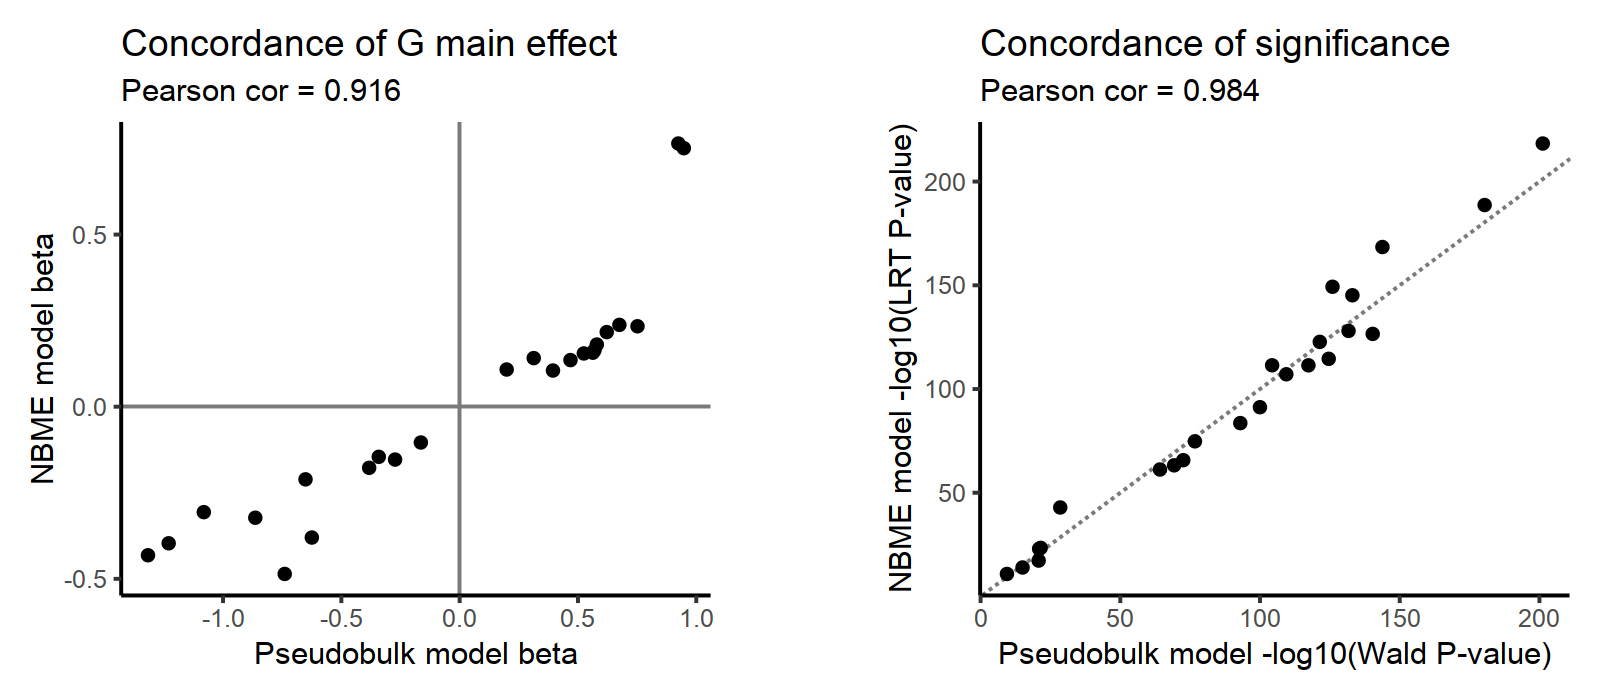

In [9]:
fig.size(3.5, 8)
pdf('../SuppFigs/NBME_pseudobulk_G_main_concordance.pdf', 
   width = 8, height = 3.5)
p1 = nbme_betas + theme(legend.position = 'none')
p2 = nbme_pvals + theme(legend.position = 'none')

p = p1 + plot_spacer() + p2 + plot_layout(widths = c(4, 0.8, 4))
print(p)
dev.off()
p

## Estimate power to detect variants across a range of allele frequencies using NBME modeling

In [1]:
suppressPackageStartupMessages({
    library(tidyr)
    library(dplyr)
    library(plyr)
    library(Matrix)
    library(lme4)
    library(Matrix.utils)
    library(singlecellmethods)
    library(MASS)
    library(glmnet)
    library(stringr)
    library(lmtest)
    library(lme4)
    library(ggplot2)
    library(ggrastr)
    library(RColorBrewer)
    library(forcats)
    library(ggrepel)
    library(symphony)
    library(irlba)
    library(hexbin)
    library(ggpubr)
    library(patchwork)
})

source('../scripts/utils.R')

Load data

In [2]:
set.seed(0)
cell_type = 'Myeloid'
gene = 'HLA-DQA1'
snp = 'rs3104413'

In [3]:
# Load Symphony object for the dataset
ref_path = paste0('/data/srlab1/jkang/hla2023/symphony/OneK1K_', cell_type, '_batch2_reference.rds') # path to ref object
ref = readRDS(ref_path)

# Load raw UMI counts matrix and metadata and gene expression PCs from Symphony object
meta = ref$meta_data
pca_res = ref$Z_orig        # pre-Harmony PCs
harmonypca_res = ref$Z_corr # post-Harmony PCs

# Load genotype dosages
geno = readRDS('/data/srlab1/jkang/hla2023/data/sampleXdosage/OneK1K_sampleXdosage_final.rds')

# Make data frame of variables for model
E = as.numeric(ref$exp_HLA[gene, ]) %>% round() # round to get integers
G = t(geno[, snp])[, as.character(meta$Sample)]
IND = as.factor(meta$Geno_ID)
B = paste0('OneK1K_', meta$Batch)
AGE = scale(meta$Age)
SEX = meta$Female
nUMI = scale(log(meta$nUMI))
MT = scale(meta$percent.mito)

dataset = meta$dataset
expPC = pca_res[1:5, ] %>% t()
    
data = data.frame(E, G, IND, B, AGE, SEX, nUMI, MT,
                   gPC1 = meta$gPC1, gPC2 = meta$gPC2, gPC3 = meta$gPC3, gPC4 = meta$gPC4, gPC5 = meta$gPC5,
                   expPC1 = expPC[,1], expPC2 = expPC[,2], expPC3 = expPC[,3], expPC4 = expPC[,4], expPC5 = expPC[,5])
data$G = as.numeric(as.character(data$G))

In [4]:
# Save the predictor data
saveRDS(data, '5_sceQTL_simulations/data_predictors.rds')

Simulate the dataset 1000 times without the genotype term

In [5]:
# Fit the model without the genotype term
model_without_G = lme4::glmer.nb(formula = E ~ (1 | IND) + (1 | B) +
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             data = data, nAGQ = 0, control = glmerControl(optimizer = "nloptwrap"))
summary(model_without_G)$coeff

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”


,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),0.036818836,2.481790e-01,0.1483559,8.820619e-01
AGE,0.031304668,2.197398e-02,1.4246247,1.542657e-01
SEX,0.034909498,4.239503e-02,0.8234336,4.102614e-01
nUMI,0.325038378,1.081318e-02,30.0594652,1.642225e-198
MT,0.007312466,7.502638e-03,0.9746526,3.297326e-01
gPC1,-13.313131375,4.487654e+01,-0.2966613,7.667251e-01
gPC2,-21.401320848,2.588201e+01,-0.8268803,4.083049e-01
gPC3,6.187811557,9.937458e+00,0.6226755,5.334978e-01
gPC4,-4.777358366,1.365037e+01,-0.3499802,7.263536e-01
gPC5,15.514568142,9.055890e+00,1.7132018,8.667541e-02


In [6]:
# Simulate the dataset 1000 times without G term
simulated_counts = simulate(model_without_G, nsim = 1000)

# Save the simulated counts data
saveRDS(simulated_counts, '5_sceQTL_simulations/simulated_counts.rds')

In [7]:
simulated_counts[[1]]

[1]    1    0    0    1    5    2    1    1    0    1    0    1    0    0
   [15]    0    1    0    1   11    1    0    0    0    0    1    0    0    0
   [29]   62    1    1    0    0    0    1    0    1    3    0    0    0    0
   [43]    2    0    1    5    0   94    0    0    0    0    1    0    0    0
   [57]    0    0    0    1    0    3    0    0    1    0    0    0    0    0
   [71]    0    0    1    2    0    5    0    0    0    0    0    1    2    0
   [85]    0    4    0    2    1    0    6    0    0    5    0    0    5    0
   [99]    0    0    7    9    0    0    1    0    3    1    1    2   19    1
  [113]    0    1    0    0    1    0    0    0    0    1    0    0    1    2
  [127]    0    0    0    0    0    1    8    0    0    0    1    1    0    0
  [141]    2    4    0    0    3    0    0    0    1    0   13    0    0   10
  [155]    1    0    1    5    0    0    0    3    0    7    1    0    0    0
  [169]    4    0    1    1    0    0    0   17    0    0    0    0    0    2
  [183]    0    1    0    0    0    0    3    0    0    0    0    1    2    1
  [197]    0    0    0    1    0    1    0    0    0    0    1    0    1    0
  [211]    0    0    0    0    1    0    0    0    4    0    0    0    0    0
  [225]    0    1    0    0    1    0    0    0    1    0    1   12    1    1
  [239]    2    0    0    0    0    0    1    0    2    2    0    0    2    0
  [253]    3    0    0    0    0    2    0    0    0    1    2    0    2    0
  [267]    0    0    0    0    0    0    0    3    1    1    2   13    0    1
  [281]    1    0    0    6    0    0    1    0    0    1    0    2    1    0
  [295]    4    0    0    8    3    1    1    0    0    2    0    0    0    0
  [309]    2    0    0    4    1    1    0    1    0    0    0    0    0    0
  [323]    0    1    0    0    8    0    2    1    0    0    3    0    0    5
  [337]    2    2    0    0    0    1    3    0    0    0    1    0    0    2
  [351]    0    0    3    0    1    0    1   26    0    0    7    1    2    0
  [365]    0    0    2    0    1    1    0    1    0    0    0    4    1    0
  [379]    0    2    0    2    0    1    0    0    2    4    0    0    0    0
  [393]    2   22    1    0    1    0    1    0    2    0    0    1    0    2
  [407]    1    0    0   50    0    0    2    1    0    0    0    0    0    0
  [421]    1    0    0    0    2    2    3    0    1   15    0    0    2    1
  [435]    0    1    6    2    1    0    0   20    0    2    1    0    1    0
  [449]    1    2    0    2    1    2    1    0    5    7    1    0    0    0
  [463]    0    0    1    0    0    2    0    0    0    0    5    0    0    3
  [477]    3    0    0    0    1    0    0    2    1    0    2    0    0    0
  [491]    0    0    0    1    8    1    4    0   13    7    9    5   11    1
  [505]   36    5    2    2  261   12   40    1    2    0   15    1   34    6
  [519]    0   11   39    1    0    5  158   25    3   17    0    3   11   13
  [533]   13    1    2   21    1    2    3   15    0    6    0    8    0    7
  [547]    0    4   80    2    1    4    0   67    1    5   88    9    1   10
  [561]    0   84    5    0   12    2    2    0    0   23    4    3    3   21
  [575]    0   10    2    5    1    1    9    0   97    1   67    1   22    5
  [589]   63  163  103   32  155    2   20    1    3    0    7   47    0    6
  [603]    2    0    0   78   13    2    6    2   50    2    1    3    0    8
  [617]    0    1    6    0   12  105    6    3    5    2    1    0    5   20
  [631]    2    8    0    4   40    0    5    0    0    0    2    0  168    2
  [645]  241    0    0    9    1   62    4    6    3    3    0    3   62    3
  [659]   36    2    2    0    0    5    4   19    1   11  158    2    1    0
  [673]    3    2    8    4    1    0    0    1    9    0    0    0   11    1
  [687]    1    3    3    0    4    4    0    3    0    0    2    0    1    0
  [701]    1    0    9    0    0    0    0    0    1    2    0    2    0    8
  [715]    3    8    1    

Confirm that the simulated data no longer has a genotype effect

In [8]:
# Fit full model on simulated data
full_model_sim <- lme4::glmer.nb(formula = simulated_counts[[1]] ~ G + (1 | IND) + (1 | B) +
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             data = data, nAGQ = 0, 
                             control = glmerControl(optimizer = "nloptwrap"))
null_model_sim <- lme4::glmer.nb(formula = simulated_counts[[1]] ~ (1 | IND) + (1 | B) +
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             data = data, nAGQ = 0, 
                             control = glmerControl(optimizer = "nloptwrap"))
summary(full_model_sim)$coeff
lrtest(full_model_sim, null_model_sim)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”


,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-0.104986869,2.450881e-01,-0.42836381,6.683863e-01
G,-0.002281809,3.806350e-02,-0.05994744,9.521975e-01
AGE,0.066748847,2.160159e-02,3.08999663,2.001588e-03
SEX,-0.016458536,4.156914e-02,-0.39593160,6.921555e-01
nUMI,0.333596110,1.052650e-02,31.69106364,2.062964e-220
MT,0.024335346,7.270286e-03,3.34723344,8.162244e-04
gPC1,-4.701445987,4.416294e+01,-0.10645682,9.152199e-01
gPC2,-68.756511696,2.541794e+01,-2.70503923,6.829632e-03
gPC3,12.447802146,9.751230e+00,1.27653659,2.017659e-01
gPC4,-15.333135234,1.340131e+01,-1.14415164,2.525608e-01


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19,-64276.72,NA,NA,NA
2,18,-64276.72,-1,0.003175063,0.9550648


## Script version starts here

In [17]:
# simulation parameters
set.seed(1)
p = 0.01 # allele frequency
genotype_effect = 0.8

coef_results = c()
sig_results = c()

simulated_counts = readRDS('5_sceQTL_simulations/simulated_counts.rds')
data = readRDS('5_sceQTL_simulations/data_predictors.rds')

In [18]:
i = 1 # this will become a for loop

Simulate the genotype dosages at desired allele frequency

In [19]:
# H-W equilibrium:
# p = 0.5 (frequency of allele A)
# q = 1-p (frequence of allele a)
# p^2 + 2*pq + q^2 = 1 # H-W equilibrium
n = length(unique(data$IND)) # num individuals

dosage_2 = p^2
dosage_1 = 2*p*(1-p)
dosage_0 = (1-p)^2
genos_sim = c(rep(2, n*dosage_2), rep(1, n*dosage_1), rep(0, n*dosage_0))
extra = n - length(genos_sim)
genos_sim = c(genos_sim, sample(c(0, 1, 2), extra))

In [20]:
length(genos_sim)
sum(genos_sim) / (2*n)

[1] 861

[1] 0.009872242

"Spike in" prespecified genotype effect to simulated expression (E_sim)

In [21]:
# Add the simulated genotypes to the data for modeling
sim_G = data.frame(cbind(unique(as.character(data$IND)), sample(genos_sim)))
colnames(sim_G) = c('IND', 'G_sim')
data_sim = left_join(data, sim_G)
data_sim$G_sim = as.numeric(data_sim$G_sim)
head(data_sim)

# Generate the simulated expression data with "spiked in" genotype effect
data_sim$E_sim = exp(log(simulated_counts[[i]]) + genotype_effect * data_sim$G_sim) %>% round()
data_sim$E_sim %>% head()

Joining, by = "IND"


,E,G,IND,B,AGE,SEX,nUMI,MT,gPC1,gPC2,gPC3,gPC4,gPC5,expPC1,expPC2,expPC3,expPC4,expPC5,G_sim
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,683_684,OneK1K_1,0.78244343,0,1.20465420,0.43666180,0.00608303,-0.001810440,-0.00792506,-0.00518905,-0.001402820,-2.341078,-11.266284,0.9025744,0.1914076,-1.0998136,0
2,4,1,682_683,OneK1K_1,0.46819257,0,0.01746739,1.79315665,0.00705345,-0.001980600,-0.01019000,-0.00532626,0.001462840,-2.553271,5.159217,2.2411682,-0.4748284,-0.9448758,0
3,0,0,684_685,OneK1K_1,0.59389291,1,-0.13172442,0.04062475,0.00600795,-0.001941500,-0.00950435,-0.00715403,-0.000999479,-2.523370,4.576786,1.5059050,-2.2399458,0.3252679,0
4,1,0,688_689,OneK1K_1,0.02824137,0,0.75698472,-0.49516631,0.00551770,0.000148497,-0.00477867,-0.00416050,0.003075440,-3.736285,-10.832988,0.7190768,-1.5142858,-0.2289150,0
5,1,1,687_688,OneK1K_1,-0.16030915,1,0.64125545,-0.16011432,0.00637981,-0.003124040,-0.01123990,-0.00550548,-0.000619825,-2.245712,2.863955,-1.0253643,-1.8703837,1.1338423,0
6,0,1,687_688,OneK1K_1,-0.16030915,1,0.03897303,0.56178515,0.00637981,-0.003124040,-0.01123990,-0.00550548,-0.000619825,-1.218001,4.904252,2.5895973,-1.0511652,-1.3188505,0


[1] 1 0 0 1 5 2

Fit full model on simulated data

In [22]:
full_model_sim <- lme4::glmer.nb(formula = E_sim ~ G_sim + (1 | IND) + (1 | B) +
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             data = data_sim, nAGQ = 0, control = glmerControl(optimizer = "nloptwrap"))
null_model_sim <- lme4::glmer.nb(formula = E_sim ~ (1 | IND) + (1 | B) +
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             data = data_sim, nAGQ = 0, control = glmerControl(optimizer = "nloptwrap"))

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”


Is the genotype effect detected?

In [23]:
summary(full_model_sim)$coeff

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-0.10358071,0.244123983,-0.42429552,6.713503e-01
G_sim,0.48995150,0.143194804,3.42157317,6.225997e-04
AGE,0.06688635,0.021537943,3.10551268,1.899495e-03
SEX,-0.01828026,0.041464874,-0.44086131,6.593134e-01
nUMI,0.33418407,0.010560882,31.64357616,9.294675e-220
MT,0.02511122,0.007288509,3.44531657,5.703910e-04
gPC1,-2.62437038,44.053223479,-0.05957272,9.524959e-01
gPC2,-66.96386538,25.321755901,-2.64451903,8.180711e-03
gPC3,12.85938504,9.726697750,1.32207100,1.861445e-01
gPC4,-14.81691984,13.367683126,-1.10841345,2.676833e-01


In [24]:
model_lrt <- lrtest(null_model_sim, full_model_sim)

In [25]:
coef_results[i] = summary(full_model_sim)$coeff['G_sim', 'Estimate']
sig_results[i] = model_lrt[2, 5]

end for loop

In [26]:
res = cbind(coef_results, sig_results) %>% as.data.frame()
res$AF = p
res$Gbeta = genotype_effect
res

coef_results,sig_results,AF,Gbeta
<dbl>,<dbl>,<dbl>,<dbl>
0.4899515,0.0006018347,0.01,0.8


In [27]:
message('Save results')
saveRDS(res, paste0('5_sceQTL_simulations/', 'res_freq_', p, '_Gbeta_', genotype_effect, '.rds'))

Save results



Ran the above code as a script across AF and beta values

## Process full results

In [45]:
toplot = NULL
for (AF in c(0.01, 0.05, 0.1, 0.2, 0.35, 0.5)) {
    for (beta in c(0.1, 0.25, 0.5, 0.75, 1.0)) {
        res = readRDS(paste0('../eqtl_single_cell/5_sceQTL_simulations/res_freq_', AF, '_Gbeta_',
                            beta, '.rds'))
        power = sum(res$sig_results < 5e-8) / 1000
        toplot = rbind(toplot, data.frame(power = power, beta = beta, AF = AF))
    }
}

png 
  2

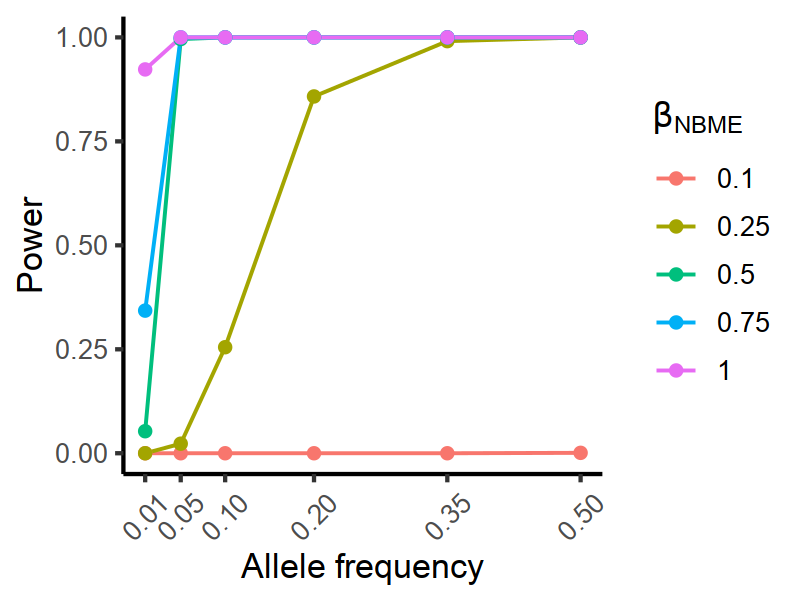

In [50]:
fig.size(3, 4)
pdf(paste('../SuppFigs/simulate_AF.pdf'), width = 4, height = 3)
p = toplot %>% ggplot() +
    geom_line(aes(x = AF, y = power, col = as.character(beta))) +
    geom_point(aes(x = AF, y = power, col = as.character(beta))) +
    theme_classic(base_size = 12) + labs(col = expression(beta[NBME])) +
    xlab('Allele frequency') + ylab('Power') +
    scale_x_continuous(breaks=c(0.01, 0.05, 0.1, 0.2, 0.35, 0.5)) +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))
print(p)
dev.off()
p

In [51]:
toplot %>% filter(beta >= 0.5)

power,beta,AF
<dbl>,<dbl>,<dbl>
0.053,0.50,0.01
0.343,0.75,0.01
0.923,1.00,0.01
0.996,0.50,0.05
1.000,0.75,0.05
1.000,1.00,0.05
1.000,0.50,0.10
1.000,0.75,0.10
1.000,1.00,0.10


In [42]:
toplot %>% filter(beta == 0.25)

power,beta,AF
<dbl>,<dbl>,<dbl>
0.000,0.25,0.01
0.023,0.25,0.05
0.255,0.25,0.10
0.858,0.25,0.20
0.991,0.25,0.35
1.000,0.25,0.50


# Done!

In [20]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1         irlba_2.3.5             symphony_0.1.0         
 [4] ggrepel_0.9.1           forcats_0.5.1           RColorBrewer_1.1-3     
 [7] ggrastr_1.0.1           ggplot2_3.3.5           lmtest_0.9-39          
[10] zoo_1.8-9               string